In [1]:
import psycopg2
import pandas as pd
from flask import Flask, jsonify
import sqlite3
import re
from typing import Pattern
import json



# Connect to gun_violence database
con = sqlite3.connect("gun_violence.sqlite")

# Read data from gunviolencedata table and load into a DataFrame instance
# raw_data = pd.read_sql("SELECT date, city_or_county, state, n_killed, n_injured from gunviolencedata WHERE (n_killed > 0 OR n_injured > 0);", con);
raw_data = pd.read_sql("SELECT date, city_or_county, state, n_killed, n_injured from gunviolencedata;", con);
pd.set_option('display.expand_frame_repr', False);
con.close()



raw_data['date'] = pd.to_datetime(raw_data['date'])

raw_data_filtered = raw_data.loc[(raw_data['date'] >= '2015-01-01')
                                & (raw_data['date'] <= '2016-12-31')]

# ----------------- Data Cleaning --------------------------------- #
# Remove all instances of "(string)" at end of city_or_county strings, if present.
raw_data_filtered["city_or_county"] = raw_data["city_or_county"].str.replace(r"\((.*?)\)", "")
raw_data['city_or_county'] = raw_data['city_or_county'].replace(['Saint Louis'], 'St. Louis')
raw_data['city_or_county'] = raw_data['city_or_county'].str.strip()
raw_data_filtered.rename(columns = {'city_or_county':'city'}, inplace = True)
raw_data_filtered['incident_count'] = 1
raw_data_filtered.to_csv('raw.csv')
raw_data_filtered.set_index(['state', 'city'], inplace=True)
# raw_data_filtered.dropna()

raw_data_filtered

/var/folders/wd/k3jgf14902jdltwk38wzc1440000gn/T/ipykernel_56995/3024727068.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  raw_data_filtered["city_or_county"] = raw_data["city_or_county"].str.replace(r"\((.*?)\)", "")
/var/folders/wd/k3jgf14902jdltwk38wzc1440000gn/T/ipykernel_56995/3024727068.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_filtered["city_or_county"] = raw_data["city_or_county"].str.replace(r"\((.*?)\)", "")
/var/folders/wd/k3jgf14902jdltwk38wzc1440000gn/T/ipykernel_56995/3024727068.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,,date,n_killed,n_injured,incident_count
state,city,,,,
Oklahoma,Tulsa,2015-01-01,0,2,1
Louisiana,Labadieville,2015-01-01,1,0,1
Mississippi,Hattiesburg,2015-01-01,0,0,1
Alabama,Bessemer,2015-01-01,0,2,1
Illinois,Chicago,2015-01-01,0,1,1
...,...,...,...,...,...
Indiana,Fort Wayne,2016-12-31,0,0,1
Arkansas,Jonesboro,2016-12-31,0,0,1
Oklahoma,Oklahoma City,2016-12-31,1,0,1


In [2]:
cities= pd.read_csv('uscities.csv')
coord = cities[['state_name','city', 'lat', 'lng', 'population']]

coord.reset_index()
coord.set_index(['state_name', 'city'], inplace=True)
coord.index = coord.index.set_names('state', level=0)



In [3]:


grouped_series = raw_data_filtered.groupby(['state', 'city'])['incident_count'].sum().sort_values(ascending=False)
grouped_series
grouped_df = grouped_series.to_frame()
grouped_df.head()
grouped_df.to_csv('grouped_df.csv')


In [4]:
grouped_df= pd.merge(grouped_df, coord, how='left', on=['state', 'city'])
grouped_df
grouped_df.to_csv('grouped_df.csv')

In [5]:
grouped_df['per_capita'] = grouped_df.eval('(incident_count/population)*100000')
grouped_filtered = grouped_df.loc[(grouped_df['population'] > 25000)]
grouped_filtered.sort_values(by='per_capita', ascending=False)

,,incident_count,lat,lng,population,per_capita
state,city,,,,,
South Carolina,Aiken,152,33.5303,-81.7271,31428.0,483.645157
Delaware,Wilmington,341,39.7415,-75.5416,70655.0,482.626849
Mississippi,Meridian,136,32.3846,-88.6896,37252.0,365.081069
Indiana,Gary,251,41.5905,-87.3473,75486.0,332.511989
Georgia,Statesboro,106,32.4375,-81.7751,32115.0,330.063833
...,...,...,...,...,...,...
Colorado,Lakewood,1,39.6977,-105.1172,155733.0,0.642125
California,Thousand Oaks,1,34.1914,-118.8756,212806.0,0.469912
Texas,McKinney,1,33.2016,-96.6670,244536.0,0.408938


In [6]:
grouped_filtered = grouped_filtered.sort_values(by='per_capita', ascending=False)
grouped_filtered.to_csv('us_per_capita.csv')
grouped_filtered.head(50)

,,incident_count,lat,lng,population,per_capita
state,city,,,,,
South Carolina,Aiken,152,33.5303,-81.7271,31428.0,483.645157
Delaware,Wilmington,341,39.7415,-75.5416,70655.0,482.626849
Mississippi,Meridian,136,32.3846,-88.6896,37252.0,365.081069
Indiana,Gary,251,41.5905,-87.3473,75486.0,332.511989
Georgia,Statesboro,106,32.4375,-81.7751,32115.0,330.063833
North Carolina,Goldsboro,95,35.3778,-77.9717,34610.0,274.487142
Massachusetts,Brockton,260,42.0821,-71.0242,95740.0,271.568832
Maryland,Annapolis,106,38.9706,-76.5047,39321.0,269.576054
Wyoming,Casper,170,42.8420,-106.3208,63962.0,265.782809


In [7]:

california = grouped_filtered.query("state == 'California'")
california = california.sort_values(by='per_capita', ascending=False)
california.head(20)

incident_count      lat       lng  population  per_capita
state      city                                                                         
California Eureka                          59  40.7943 -124.1564     26938.0  219.021457
           Desert Hot Springs              33  33.9550 -116.5429     29280.0  112.704918
           Oakland                        471  37.7904 -122.2166    422575.0  111.459504
           Salinas                        171  36.6883 -121.6317    190345.0   89.836875
           Atwater                         25  37.3529 -120.5959     30336.0   82.410338
           Richmond                        82  37.9477 -122.3389    110051.0   74.510909
           Fresno                         510  36.7830 -119.7939    702486.0   72.599312
           Coachella                       29  33.6905 -116.1430     45658.0   63.515704
           San Bernardino                 132  34.1416 -117.2943    216784.0   60.890103
           Pasadena                        81  34.1597 -118.1390    142017.0   57.035425
           Santa Paula                     16  34.3545 -119.0656     30297.0   52.810509
           Merced                          74  37.3057 -120.4779    147690.0   50.104950
           Compton                         45  33.8930 -118.2274     95804.0   46.970899
           Palm Springs                    21  33.8017 -116.5382     48390.0   43.397396
           Oxnard                         162  34.1964 -119.1815    378990.0   42.745191
           Bakersfield                    220  35.3529 -119.0359    556892.0   39.504967
           Santa Ana                      122  33.7367 -117.8819    332610.0   36.679595
           Norwalk                         38  33.9069 -118.0829    104524.0   36.355287
           Soledad                          9  36.4432 -121.3426     25667.0   35.064480
           Cathedral City                  19  33.8362 -116.4642     54812.0   34.663942

In [12]:
states= pd.read_csv('state.csv')
states.reset_index()
states.set_index('state', inplace=True)
states.sort_index()

,population
state,
Alabama,5039877
Alaska,732673
Arizona,7276316
Arkansas,3025891
California,39237836
Colorado,5812069
Connecticut,3605597
Delaware,1003384
District of Columbia,670050


In [13]:


state_groups = raw_data_filtered.groupby('state')['incident_count'].sum()
state_groups = state_groups.to_frame()
state_groups.reset_index()
state_groups.sort_index()


,incident_count
state,
Alabama,2343
Alaska,825
Arizona,1034
Arkansas,1258
California,6851
Colorado,1600
Connecticut,1540
Delaware,694
District of Columbia,1035


In [25]:
grouped_states= pd.merge(state_groups, states, how='left', on='state')
fred = grouped_states['population'].astype('int')
grouped_states['per_capita'] = grouped_states.eval('(incident_count/population)*100000')
grouped_states.sort_values(by='per_capita', ascending=False)
grouped_states


,incident_count,population,per_capita
state,,,
Alabama,2343,5039877,46.489230
Alaska,825,732673,112.601392
Arizona,1034,7276316,14.210488
Arkansas,1258,3025891,41.574531
California,6851,39237836,17.460188
Colorado,1600,5812069,27.528923
Connecticut,1540,3605597,42.711373
Delaware,694,1003384,69.165942
District of Columbia,1035,670050,154.466085


In [15]:
grouped_states.info()
extracted1 = grouped_states['population']
extracted2 = grouped_states['per_capita']
extracted3 = grouped_states['incident_count']

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, Alabama to Wyoming
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   incident_count  51 non-null     int64  
 1   population      51 non-null     int64  
 2   per_capita      51 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.6+ KB


In [26]:
political = pd.read_csv('clean_political_affiliation.csv')
political.info()

# political['Gov_Political_Affiliation', 'State']
# political = political.drop(['Unnamed: 0'], axis=1)
# political.set_index(['State'])
# grouped_states = grouped_states.join(gov)
# grouped_states
political.rename(columns = {'State':'state'}, inplace = True)
political.reindex()
political.set_index('state', inplace=True)
# political.drop(['Unnamed: 0'], axis=1)
grouped_states = pd.merge(grouped_states, political, on=['state'])
# grouped_states.drop(['Unnamed: 0'], axis=1)
sort = grouped_states.sort_values(by='per_capita')
# sorted_df = df_marks.sort_values(by='algebra')
grouped_states.reset_index(inplace=True)
grouped_states.rename(columns = {'index':'state'})





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 51 non-null     int64  
 1   State                      51 non-null     object 
 2   Gov_Political_Affiliation  51 non-null     object 
 3   Lat                        51 non-null     float64
 4   Long                       51 non-null     float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.1+ KB


,state,incident_count,population,per_capita,Unnamed: 0,Gov_Political_Affiliation,Lat,Long
0,Alabama,2343,5039877,46.489230,0,Republican,32.318231,-86.902298
1,Alaska,825,732673,112.601392,1,Republican,63.588753,-154.493062
2,Arizona,1034,7276316,14.210488,2,Republican,34.048928,-111.093731
3,Arkansas,1258,3025891,41.574531,3,Republican,35.201050,-91.831833
4,California,6851,39237836,17.460188,4,Democrat,36.778261,-119.417932
5,Colorado,1600,5812069,27.528923,5,Democrat,39.550051,-105.782067
6,Connecticut,1540,3605597,42.711373,6,Democrat,41.603221,-73.087749
7,Delaware,694,1003384,69.165942,7,Democrat,38.910832,-75.527670
8,District of Columbia,1035,670050,154.466085,8,Democrat,38.905985,-77.033418
9,Florida,6903,21781128,31.692573,9,Republican,27.664827,-81.515754


In [31]:
grouped_states.to_csv('state_data.csv')




RuntimeError: Working outside of application context.

This typically means that you attempted to use functionality that needed
to interface with the current application object in some way. To solve
this, set up an application context with app.app_context().  See the
documentation for more information.

In [18]:


state_stats1 = grouped_states[['state', 'population', 'per_capita', 'Gov_Political_Affiliation']]
state_stats1 = state_stats1.drop(index=8)
state_stats1

grouped_series = raw_data_filtered.groupby(['state', 'city'])['incident_count'].sum().sort_values(ascending=False)

grouped_stat_stats = state_stats1.groupby(['Gov_Political_Affiliation'])['per_capita'].mean()
grouped_stat_stats


Gov_Political_Affiliation
Democrat      35.735934
Republican    40.794257
Name: per_capita, dtype: float64

In [19]:
# Blue_states = state_stats1[state_stats1['Gov_Political_Affiliation'] == 'Democrat']
Blue_states = state_stats1['per_capita'][state_stats1['Gov_Political_Affiliation'] == 'Democrat']
Blue_states.name = 'Democrat'
Blue_States = Blue_states.reset_index()
Red_states = state_stats1['per_capita'][state_stats1['Gov_Political_Affiliation'] == 'Republican']
Red_States = Red_states.reset_index()
Red_states.name = 'Republican'
Red_States.to_csv('red.csv')
Blue_States.to_csv('blue.csv')

# RedBlue=pd.concat([Red_states,Blue_states],axis=1)
# RedBlue



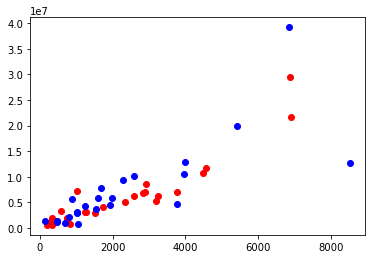

In [20]:
from matplotlib.axis import YAxis
import matplotlib.pyplot as plt

xblue = grouped_states[grouped_states['Gov_Political_Affiliation']=='Democrat']
xred = grouped_states[grouped_states['Gov_Political_Affiliation']=='Republican']
x = xred['incident_count'].values
y = xred['population'].values
plt.scatter(x, y, c='red')
x = xblue['incident_count'].values
y = xblue['population'].values
plt.scatter(x, y, c='blue')

plt.show()


In [21]:
import plotly.express as px

px.pie(grouped_states, names='Gov_Political_Affiliation', color='Gov_Political_Affiliation', color_discrete_map={'Republican':'red',
                                 'Democrat':'blue'}, title="Blue-Red States")



In [22]:
px.box(state_stats1, y ='per_capita', x='Gov_Political_Affiliation', title='Box & Whisker Plot of Per Capita Incidents', hover_data=['state'],\
    labels={'Gov_Political_Affiliation':'State Polticial Leaning', 'per_capita':'gun incidents'})

In [23]:


px.bar(state_stats1.groupby(['Gov_Political_Affiliation'])['per_capita'].mean(), labels={
                     "Gov_Political_Affiliation": "Mean Gun Incidents by Poltical Leaning (States)",
                     "value": "Incidents",
                     "per_capita": "incident average"})

In [24]:
fig = px.scatter(grouped_states, x='per_capita', y='incident_count', size='per_capita',\
    color='Gov_Political_Affiliation')
fig.show()